<a id = 'home' ></a>

# Liver Problem Analysis - Baseline

1. [**Libraries and Analyzing the Data**](#libraries) <a href = '#libraries'></a>
    - No null values
    - No variables with either Single Value or All Unique Values
    - [**Correlation Analysis**](#cor) <a href = '#cor'></a>
        - Some expected outputs:
            - Total_Bilirubin & Direct_Bilirubin (0.78)
            - Total_Protiens & Albumin (0.83)
            - Albumin_and_Globulin_Ratio & Albumin (0.74)
    - [**Creating 10 bins for Age variable**](#bin) <a href = '#bin'></a>            
2. [**Standardization and Dummies of Cat Vars**](#stddum) <a href = '#stddum'></a>
    - [**Creating scaled data**](#sc) <a href = '#sc'></a>
3. [**Model Building**](#model) <a href = '#model'></a>
    - [**A. Logistic Regression**](#lg) <a href = '#lg'></a>
        - [**i. Model on unscaled data**](#lguns) <a href = '#lguns'></a> **85.37**
        - [**ii. Model on scaled data**](#lgs) <a href = '#lgs'></a> **79.27**
        - [**iii. Model on unscaled data without 'Age' variable**](#lguns1) <a href = '#lguns1'></a> **84.15**
        - [**iv. Model on unscaled data without 'Albumin' variable**](#alb) <a href = '#alb'></a> **84.15**
    - [**B. Random Forest**](#rf) <a href = '#rf'></a> **80.49**
        - [**i. Grid Search and CV**](#gs) <a href = '#gs'></a> **75.61**

## 1. Libraries and Analyzing the Data <a id = 'libraries' ></a>

[Home](#home) <a href = '#home'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
import copy

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
liver_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/liver_patient_data/indian_liver_patient_dataset.csv')
liver_data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Problem
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/liver_patient_data/indian_liver_patient_new_testdataset.csv')
test_new.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,36,Male,2.8,1.5,305,28,76,5.9,2.5,0.7
1,42,Male,0.8,0.2,127,29,30,4.9,2.7,1.2
2,53,Male,19.8,10.4,238,39,221,8.1,2.5,0.4
3,32,Male,30.5,17.1,218,39,79,5.5,2.7,0.9
4,32,Male,32.6,14.1,219,95,235,5.8,3.1,1.1


In [4]:
print(liver_data.shape)
print(test_new.shape)

(500, 11)
(82, 10)


#### Checking Data Types

In [5]:
liver_data.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Liver_Problem                   int64
dtype: object

In [6]:
test_new.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
dtype: object

#### Checking NAs

In [7]:
liver_data.isna().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Liver_Problem                 0
dtype: int64

In [8]:
test_new.isna().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
dtype: int64

In [9]:
n_col = ['Albumin_and_Globulin_Ratio']

In [10]:
from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer
mean_imputer = Imputer(strategy="mean", axis=0)
mean_imputer.fit(liver_data[n_col])
liver_data[n_col] = pd.DataFrame(mean_imputer.fit_transform(liver_data[n_col]))

C:\Users\BINAI\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
liver_data.isna().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Liver_Problem                 0
dtype: int64

#### Correlation Analysis <a id = 'cor' ></a>
[Home](#home) <a href = '#home'></a>

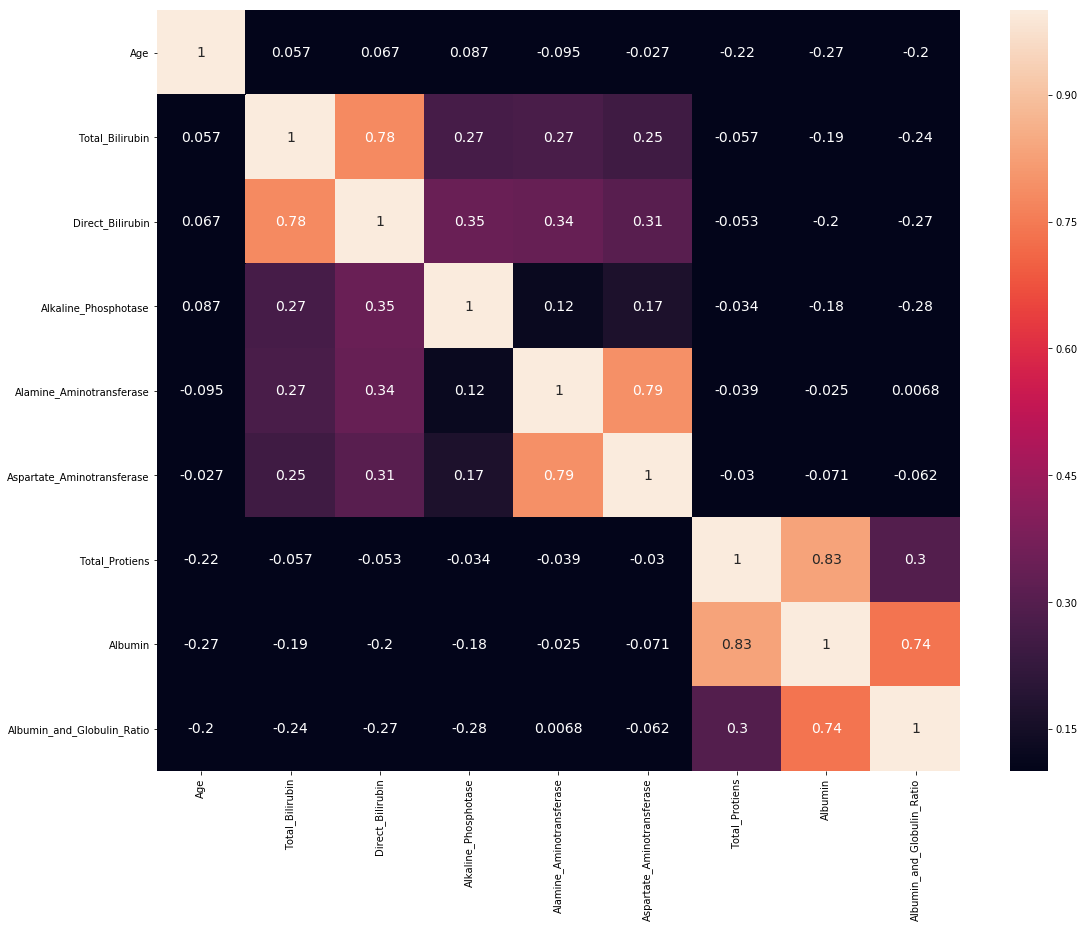

In [12]:
cor = liver_data[['Age','Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio']]

plt.figure(figsize = (18,14))
sns.heatmap(cor.corr(), vmin=cor.values.min(), vmax=1, annot=True, annot_kws={"size":14}, square = False)
plt.show()

#### Creating 10 bins for Age variable   <a id = 'bin' ></a>
[Home](#home) <a href = '#home'></a>

In [13]:
liver_data.Age.describe()

count    500.0000
mean      44.5860
std       16.5334
min        4.0000
25%       32.7500
50%       45.0000
75%       58.0000
max       85.0000
Name: Age, dtype: float64

In [14]:
test_new.Age.describe()

count    82.000000
mean     45.414634
std      13.814424
min      10.000000
25%      37.250000
50%      46.000000
75%      53.000000
max      90.000000
Name: Age, dtype: float64

In [15]:
liver_data['deciles'] = pd.qcut(liver_data['Age'], q=10, precision=0)
test_new['deciles'] = pd.qcut(test_new['Age'], q=10, precision=0)

In [16]:
X = liver_data.copy().drop('Liver_Problem', axis = 1)
y = liver_data['Liver_Problem']

In [17]:
X_num = len(X)
combined_dataset = pd.concat(objs=[X, test_new], axis=0)

In [18]:
combined_dataset['deciles'] = pd.qcut(combined_dataset['Age'], q=10, precision=0)

In [19]:
X = copy.copy(combined_dataset[:X_num])
test = copy.copy(combined_dataset[X_num:])

print(X.shape)
print(y.shape)
print(test.shape)

(500, 11)
(500,)
(82, 11)


In [20]:
X.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,deciles
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,"(60.0, 66.0]"
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,"(60.0, 66.0]"
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,"(60.0, 66.0]"
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,"(55.0, 60.0]"
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,"(66.0, 90.0]"


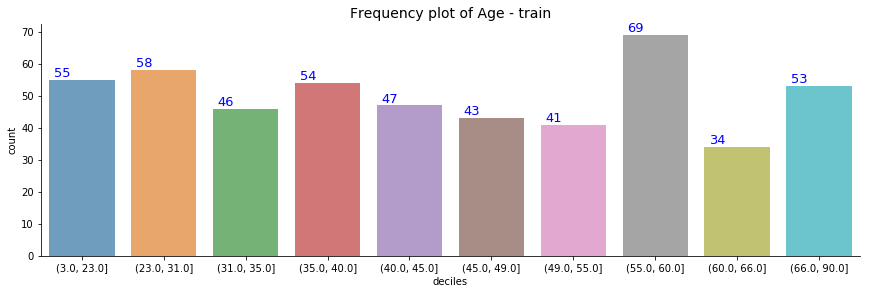

In [21]:
sns.catplot('deciles', data= X, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = X['deciles'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of Age - train', fontsize = 14, color = 'black')
plt.show()

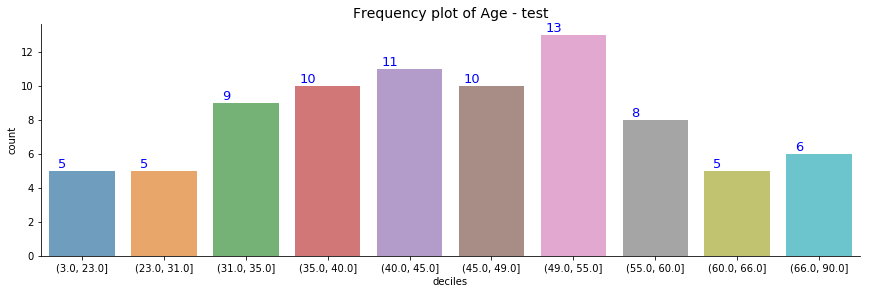

In [22]:
sns.catplot('deciles', data= test, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = test['deciles'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of Age - test', fontsize = 14, color = 'black')
plt.show()

In [23]:
# Extracting numerical columns for standardization exploration
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
num_cols

Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [24]:
# Creating sets without 'Age' variable for analysis
X_2 = X.drop('Age', axis = 1)
test_2 = test.drop('Age', axis = 1)

In [25]:
cols = X_2.columns
num_cols_2 = X_2._get_numeric_data().columns
cat_cols_2 = list(set(cols) - set(num_cols))
num_cols_2

Index(['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

#### Checking column/s to change to Categorical

In [26]:
print('For Train')
d1 = liver_data.nunique()
print(sorted(d1))
print("==============================")
print('For Test')
d2 = test_new.nunique()
print(sorted(d2))

For Train
[2, 2, 10, 39, 57, 61, 64, 70, 87, 141, 154, 235]
For Test
[2, 10, 18, 31, 35, 35, 41, 50, 53, 67, 71]


In [27]:
col_train = X.columns
col_test = test.columns

In [28]:
l1 = []
for i in col_train:
    if X[i].nunique() <= 10:
        l1.append(i)

In [29]:
l2 = []
for i in col_test:
    if test[i].nunique() <= 10:
        l2.append(i)

In [30]:
# Checking the columns in train and test are same or not
df = pd.DataFrame(l1, columns = ['train'])
df['test'] = pd.DataFrame(l2)
df

,train,test
0,Gender,Gender
1,deciles,deciles


## 2. Standardization and Dummies of Cat Vars <a id = 'stddum' ></a>

[Home](#home) <a href = '#home'></a>

In [31]:
l1

['Gender', 'deciles']

In [32]:
X_num = len(X)
combined_dataset = pd.concat(objs=[X, test], axis=0)

In [33]:
combined_dataset = pd.get_dummies(combined_dataset, columns=l1, drop_first=True)

In [34]:
X = copy.copy(combined_dataset[:X_num])
test = copy.copy(combined_dataset[X_num:])

In [35]:
print(X.shape)
print(y.shape)
print(test.shape)

(500, 19)
(500,)
(82, 19)


In [74]:
X_num_2 = len(X_2)
combined_dataset_2 = pd.concat(objs=[X_2, test_2], axis=0)

In [75]:
combined_dataset_2 = pd.get_dummies(combined_dataset_2, columns=l1, drop_first=True)

In [76]:
X_2 = copy.copy(combined_dataset_2[:X_num_2])
test_2 = copy.copy(combined_dataset_2[X_num_2:])

In [77]:
print(X_2.shape)
print(y.shape)
print(test_2.shape)

(500, 18)
(500,)
(82, 18)


#### Creating scaled data<a id = 'sc' ></a>

[Home](#home) <a href = '#home'></a>

In [36]:
trainscaled = X.copy()
testscaled = test.copy()

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainscaled[num_cols])

trainscaled[num_cols]=scaler.transform(trainscaled[num_cols])

In [38]:
print(trainscaled.shape)

(500, 19)


In [39]:
scaler.fit(testscaled[num_cols])

testscaled[num_cols]=scaler.transform(testscaled[num_cols])
print(test.shape)

(82, 19)


## 3. Model Building <a id = 'model' ></a>

[Home](#home) <a href = '#home'></a>

In [40]:
# Split for unscaled data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 45)

In [41]:
# Split for scaled data
Xs_train, Xs_val, ys_train, ys_val = train_test_split(trainscaled, y, test_size=0.3, random_state = 45)

### A. Logistic Regression <a id = 'lg' ></a>

[Home](#home) <a href = '#home'></a>

In [42]:
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#### Model on unscaled data<a id = 'lguns' ></a>

[Home](#home) <a href = '#home'></a>

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
# Predict (train)
y_train_pred = logreg.predict(X_train)

In [45]:
# Model evaluation (train)
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
print('Evaluation on train set')
print('----------------------------')
print('Accuracy on unscaled data: ', acc)
print('f1 score on unscaled data: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_train, y_train_pred))

Evaluation on train set
----------------------------
Accuracy on unscaled data:  0.7314285714285714
f1 score on unscaled data:  0.8206106870229009
Confusion Matrix: 
[[215  24]
 [ 70  41]]


In [46]:
# Predict (val)
y_val_pred = logreg.predict(X_val)

In [47]:
# Model evaluation (val)
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
print('Evaluation on validation set')
print('----------------------------')
print('Accuracy on unscaled data: ', acc)
print('f1 score on unscaled data: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_val, y_val_pred))

Evaluation on validation set
----------------------------
Accuracy on unscaled data:  0.7533333333333333
f1 score on unscaled data:  0.8398268398268398
Confusion Matrix: 
[[97 14]
 [23 16]]


In [48]:
test['Liver_Problem'] = logreg.predict(test)
test.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,36,2.8,1.5,305,28,76,5.9,2.5,0.7,1,0,0,1,0,0,0,0,0,0,1
1,42,0.8,0.2,127,29,30,4.9,2.7,1.2,1,0,0,0,1,0,0,0,0,0,2
2,53,19.8,10.4,238,39,221,8.1,2.5,0.4,1,0,0,0,0,0,1,0,0,0,1
3,32,30.5,17.1,218,39,79,5.5,2.7,0.9,1,0,1,0,0,0,0,0,0,0,1
4,32,32.6,14.1,219,95,235,5.8,3.1,1.1,1,0,1,0,0,0,0,0,0,0,1


In [49]:
submission = test[['Liver_Problem']]
submission.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [51]:
submission.to_csv("submission_logreg.csv",index=False)

#### Model on scaled data<a id = 'lgs' ></a>

[Home](#home) <a href = '#home'></a>

In [52]:
logregsc = LogisticRegression()
logregsc.fit(Xs_train, ys_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
# Predict (train)
ys_train_pred = logregsc.predict(Xs_train)

# Model evaluation (train)
acc = accuracy_score(ys_train, ys_train_pred)
f1 = f1_score(ys_train, ys_train_pred)
print('Evaluation on train set')
print('----------------------------')
print('Accuracy on scaled data: ', acc)
print('f1 score on scaled data: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(ys_train, ys_train_pred))

Evaluation on train set
----------------------------
Accuracy on scaled data:  0.7257142857142858
f1 score on scaled data:  0.8181818181818182
Confusion Matrix: 
[[216  23]
 [ 73  38]]


In [54]:
# Predict (val)
ys_val_pred = logregsc.predict(Xs_val)

# Model evaluation (val)
acc = accuracy_score(ys_val, ys_val_pred)
f1 = f1_score(ys_val, ys_val_pred)
print('Evaluation on validation set')
print('----------------------------')
print('Accuracy on scaled data: ', acc)
print('f1 score on scaled data: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(ys_val, ys_val_pred))

Evaluation on validation set
----------------------------
Accuracy on scaled data:  0.7666666666666667
f1 score on scaled data:  0.849785407725322
Confusion Matrix: 
[[99 12]
 [23 16]]


In [61]:
testscaled = testscaled.drop('Liver_Problem', axis = 1)
testscaled['Liver_Problem'] = logregsc.predict(testscaled)
testscaled.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,-0.685701,-0.491499,-0.456238,0.429381,-0.498601,-0.303352,-0.793594,-0.647726,-0.386241,1,0,0,1,0,0,0,0,0,0,1
1,-0.248700,-0.698712,-0.721134,-1.078980,-0.486323,-0.641786,-1.757665,-0.381493,0.766298,1,0,0,0,1,0,0,0,0,0,2
2,0.552469,1.269811,1.357283,-0.138373,-0.363545,0.763450,1.327360,-0.647726,-1.077765,1,0,0,0,0,0,1,0,0,0,1
3,-0.977036,2.378400,2.722519,-0.307852,-0.363545,-0.281280,-1.179223,-0.381493,0.074775,1,0,1,0,0,0,0,0,0,0,1
4,-0.977036,2.595974,2.111219,-0.299378,0.324016,0.866451,-0.890001,0.150974,0.535790,1,0,1,0,0,0,0,0,0,0,1


In [62]:
submissionsc = testscaled[['Liver_Problem']]
submissionsc.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [63]:
submissionsc.to_csv("submission_logregsc.csv",index=False)

#### Model on unscaled data without 'Age' variable <a id = 'lguns1' ></a>

[Home](#home) <a href = '#home'></a>

In [78]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_2, y, test_size=0.2, random_state = 45)

In [79]:
logreg_1 = LogisticRegression()
logreg_1.fit(X_train_1, y_train_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
# Predict (train)
y_train_pred_1 = logreg_1.predict(X_train_1)

# Model evaluation (train)
acc = accuracy_score(y_train_1, y_train_pred_1)
f1 = f1_score(y_train_1, y_train_pred_1)
print('Evaluation on train set')
print('----------------------------')
print('Accuracy: ', acc)
print('f1 score: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_train_1, y_train_pred_1))

Evaluation on train set
----------------------------
Accuracy:  0.715
f1 score:  0.8125
Confusion Matrix: 
[[247  28]
 [ 86  39]]


In [82]:
# Predict (val)
y_val_pred_1 = logreg_1.predict(X_val_1)

# Model evaluation (val)
acc = accuracy_score(y_val_1, y_val_pred_1)
f1 = f1_score(y_val_1, y_val_pred_1)
print('Evaluation on validation set')
print('----------------------------')
print('Accuracy: ', acc)
print('f1 score: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_val_1, y_val_pred_1))

Evaluation on validation set
----------------------------
Accuracy:  0.76
f1 score:  0.8421052631578949
Confusion Matrix: 
[[64 11]
 [13 12]]


In [83]:
test_2['Liver_Problem'] = logreg_1.predict(test_2)
test_2.head()

,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,2.8,1.5,305,28,76,5.9,2.5,0.7,1,0,0,1,0,0,0,0,0,0,1
1,0.8,0.2,127,29,30,4.9,2.7,1.2,1,0,0,0,1,0,0,0,0,0,2
2,19.8,10.4,238,39,221,8.1,2.5,0.4,1,0,0,0,0,0,1,0,0,0,1
3,30.5,17.1,218,39,79,5.5,2.7,0.9,1,0,1,0,0,0,0,0,0,0,1
4,32.6,14.1,219,95,235,5.8,3.1,1.1,1,0,1,0,0,0,0,0,0,0,1


In [84]:
submission_2 = test_2[['Liver_Problem']]
submission_2.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [85]:
submission_2.to_csv("submission_logreg_2.csv",index=False)

#### Model on unscaled data without 'Albumin' variable <a id = 'alb' ></a>

[Home](#home) <a href = '#home'></a>

In [97]:
X_3 = X.drop('Albumin', axis=1)
test_3 = test.drop(['Liver_Problem', 'Albumin'], axis=1) # Target variable was added in previous prediction

In [99]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_3, y, test_size=0.2, random_state = 45)

In [100]:
logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2, y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [101]:
# Predict (train)
y_train_pred_2 = logreg_2.predict(X_train_2)

# Model evaluation (train)
acc = accuracy_score(y_train_2, y_train_pred_2)
f1 = f1_score(y_train_2, y_train_pred_2)
print('Evaluation on train set')
print('----------------------------')
print('Accuracy: ', acc)
print('f1 score: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_train_2, y_train_pred_2))

Evaluation on train set
----------------------------
Accuracy:  0.715
f1 score:  0.8093645484949832
Confusion Matrix: 
[[242  33]
 [ 81  44]]


In [102]:
# Predict (val)
y_val_pred_2 = logreg_2.predict(X_val_2)

# Model evaluation (val)
acc = accuracy_score(y_val_2, y_val_pred_2)
f1 = f1_score(y_val_2, y_val_pred_2)
print('Evaluation on validation set')
print('----------------------------')
print('Accuracy: ', acc)
print('f1 score: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_val_2, y_val_pred_2))

Evaluation on validation set
----------------------------
Accuracy:  0.74
f1 score:  0.8266666666666667
Confusion Matrix: 
[[62 13]
 [13 12]]


In [103]:
test_3['Liver_Problem'] = logreg_2.predict(test_3)
test_3.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,36,2.8,1.5,305,28,76,5.9,0.7,1,0,0,1,0,0,0,0,0,0,1
1,42,0.8,0.2,127,29,30,4.9,1.2,1,0,0,0,1,0,0,0,0,0,2
2,53,19.8,10.4,238,39,221,8.1,0.4,1,0,0,0,0,0,1,0,0,0,1
3,32,30.5,17.1,218,39,79,5.5,0.9,1,0,1,0,0,0,0,0,0,0,1
4,32,32.6,14.1,219,95,235,5.8,1.1,1,0,1,0,0,0,0,0,0,0,1


In [104]:
submission_3 = test_3[['Liver_Problem']]
submission_3.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [105]:
submission_3.to_csv("submission_logreg_3.csv",index=False)

### B. Random Forest <a id = 'rf' ></a>

[Home](#home) <a href = '#home'></a>

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
rf1.fit(X = X_train,y = y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
# Predict (train)
y_train_pred_rf = rf1.predict(X_train)

# Model evaluation (train)
acc = accuracy_score(y_train, y_train_pred_rf)
f1 = f1_score(y_train, y_train_pred_rf)
print('Evaluation on train set')
print('----------------------------')
print('RF: Accuracy: ', acc)
print('RF: f1 scorea: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_train, y_train_pred_rf))

Evaluation on train set
----------------------------
RF: Accuracy:  0.9857142857142858
RF: f1 scorea:  0.989648033126294
Confusion Matrix: 
[[239   0]
 [  5 106]]


In [67]:
# Predict (val)
y_val_pred_rf = rf1.predict(X_val)

# Model evaluation (train)
acc = accuracy_score(y_val, y_val_pred_rf)
f1 = f1_score(y_val, y_val_pred_rf)
print('Evaluation on train set')
print('----------------------------')
print('RF: Accuracy: ', acc)
print('RF: f1 scorea: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_val, y_val_pred_rf))

Evaluation on train set
----------------------------
RF: Accuracy:  0.7533333333333333
RF: f1 scorea:  0.8412017167381974
Confusion Matrix: 
[[98 13]
 [24 15]]


In [68]:
test = test.drop('Liver_Problem', axis=1)
test['Liver_Problem'] = rf1.predict(test)
test.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,36,2.8,1.5,305,28,76,5.9,2.5,0.7,1,0,0,1,0,0,0,0,0,0,1
1,42,0.8,0.2,127,29,30,4.9,2.7,1.2,1,0,0,0,1,0,0,0,0,0,2
2,53,19.8,10.4,238,39,221,8.1,2.5,0.4,1,0,0,0,0,0,1,0,0,0,1
3,32,30.5,17.1,218,39,79,5.5,2.7,0.9,1,0,1,0,0,0,0,0,0,0,1
4,32,32.6,14.1,219,95,235,5.8,3.1,1.1,1,0,1,0,0,0,0,0,0,0,1


In [69]:
submission_rf = test[['Liver_Problem']]
submission_rf.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [71]:
submission_rf.to_csv("submission_rfc.csv",index=False)

#### Grid Search and CV <a id = 'gs' ></a>

[Home](#home) <a href = '#home'></a>

In [107]:
rfgs = RandomForestClassifier(random_state=45)

In [119]:
param_grid = { 
    'n_estimators': [3, 5, 8, 10, 12, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [120]:
cv_rfc = GridSearchCV(estimator=rfgs, param_grid=param_grid, cv= 5)
cv_rfc.fit(X_train, y_train)

C:\Users\BINAI\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=45, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [3, 5, 8, 10, 12, 15], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 12}

In [122]:
rfgs1 = RandomForestClassifier(random_state=45, max_features='auto', n_estimators= 12, max_depth=4, criterion='gini')

In [123]:
rfgs1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=None,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

In [124]:
# Predict (train)
y_train_pred_rfgs = rfgs1.predict(X_train)

# Model evaluation (train)
acc = accuracy_score(y_train, y_train_pred_rfgs)
f1 = f1_score(y_train, y_train_pred_rfgs)
print('Evaluation on train set')
print('----------------------------')
print('RFGS: Accuracy: ', acc)
print('RFGS: f1 scorea: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_train, y_train_pred_rfgs))

Evaluation on train set
----------------------------
RFGS: Accuracy:  0.7971428571428572
RFGS: f1 scorea:  0.8647619047619047
Confusion Matrix: 
[[227  12]
 [ 59  52]]


In [125]:
# Predict (val)
y_val_pred_rfgs = rfgs1.predict(X_val)

# Model evaluation (train)
acc = accuracy_score(y_val, y_val_pred_rfgs)
f1 = f1_score(y_val, y_val_pred_rfgs)
print('Evaluation on train set')
print('----------------------------')
print('RFGS: Accuracy: ', acc)
print('RFGS: f1 scorea: ', f1)
print('Confusion Matrix: ')
print(confusion_matrix(y_val, y_val_pred_rfgs))

Evaluation on train set
----------------------------
RFGS: Accuracy:  0.74
RFGS: f1 scorea:  0.8340425531914892
Confusion Matrix: 
[[98 13]
 [26 13]]


In [126]:
test = test.drop('Liver_Problem', axis=1)
test['Liver_Problem'] = rfgs1.predict(test)
test.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male,"deciles_(23.0, 31.0]","deciles_(31.0, 35.0]","deciles_(35.0, 40.0]","deciles_(40.0, 45.0]","deciles_(45.0, 49.0]","deciles_(49.0, 55.0]","deciles_(55.0, 60.0]","deciles_(60.0, 66.0]","deciles_(66.0, 90.0]",Liver_Problem
0,36,2.8,1.5,305,28,76,5.9,2.5,0.7,1,0,0,1,0,0,0,0,0,0,1
1,42,0.8,0.2,127,29,30,4.9,2.7,1.2,1,0,0,0,1,0,0,0,0,0,2
2,53,19.8,10.4,238,39,221,8.1,2.5,0.4,1,0,0,0,0,0,1,0,0,0,1
3,32,30.5,17.1,218,39,79,5.5,2.7,0.9,1,0,1,0,0,0,0,0,0,0,1
4,32,32.6,14.1,219,95,235,5.8,3.1,1.1,1,0,1,0,0,0,0,0,0,0,1


In [127]:
submission_rfgs = test[['Liver_Problem']]
submission_rfgs.head()

,Liver_Problem
0,1
1,2
2,1
3,1
4,1


In [128]:
submission_rfgs.to_csv("submission_rfgs.csv",index=False)